In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [9]:
# Load and Transform Data
df = pd.read_csv('data.csv', encoding='latin1')
x = df['no2'].dropna().values.reshape(-1, 1)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

#Transformation function
r = 102317254
ar = 0.5 * (r % 7)
br = 0.3 * (r % 5 + 1)
zreal = x_scaled + ar * np.sin(br * x_scaled)
zreal_tensor = torch.FloatTensor(zreal)

/tmp/ipython-input-2096928608.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv', encoding='latin1')


In [11]:
# generator and discriminator

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


netG = Generator()
netD = Discriminator()
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)

In [18]:
#training loop
epochs = 5000
batch_size = 128

for epoch in range(epochs):

    netD.zero_grad()

    # Real
    idx = np.random.randint(0, zreal.shape[0], batch_size)
    real_samp = zreal_tensor[idx]
    label_real = torch.ones(batch_size, 1)
    output_real = netD(real_samp)
    lossD_real = criterion(output_real, label_real)

    # Fake
    noise = torch.randn(batch_size, 1)
    fake_samples = netG(noise)
    label_fake = torch.zeros(batch_size, 1)
    output_fake = netD(fake_samples.detach())
    lossD_fake = criterion(output_fake, label_fake)

    lossD = lossD_real + lossD_fake
    lossD.backward()
    optimizerD.step()

    # Update Generator
    netG.zero_grad()
    output = netD(fake_samples)
    lossG = criterion(output, label_real)
    lossG.backward()
    optimizerG.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}/{epochs} | Loss D: {lossD.item():.4f} | Loss G: {lossG.item():.4f}")

Epoch 0/5000 | Loss D: 1.3872 | Loss G: 0.6829
Epoch 1000/5000 | Loss D: 1.3823 | Loss G: 0.6998
Epoch 2000/5000 | Loss D: 1.3874 | Loss G: 0.6969
Epoch 3000/5000 | Loss D: 1.3827 | Loss G: 0.6888
Epoch 4000/5000 | Loss D: 1.3801 | Loss G: 0.7006


/tmp/ipython-input-74950797.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(zreal.flatten(), label='Real Transformed Data (z)', shade=True)
/tmp/ipython-input-74950797.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(generated_z.flatten(), label='GAN Generated Data (z_f)', shade=True)


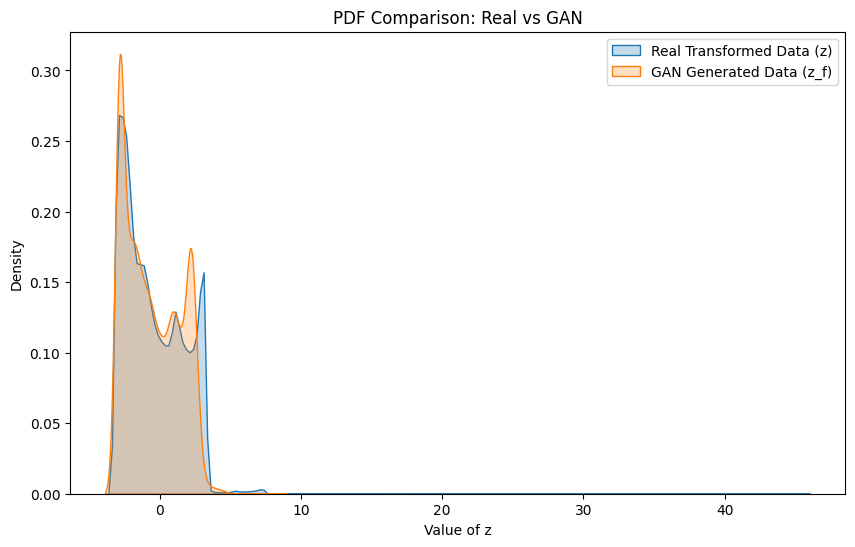

In [19]:
# results and visualization

with torch.no_grad():
    test_noise = torch.randn(10000, 1)
    generated_z = netG(test_noise).numpy()

plt.figure(figsize=(10, 6))
sns.kdeplot(zreal.flatten(), label='Real Transformed Data (z)', shade=True)
sns.kdeplot(generated_z.flatten(), label='GAN Generated Data (z_f)', shade=True)
plt.title(f"PDF Comparison: Real vs GAN")
plt.xlabel("Value of z")
plt.ylabel("Density")
plt.legend()
plt.show()